# Build a self-supervised learning pipeline

This notebook will explain how to use the selfeeg library to build a self-supervised learning pipeline. 

To summarize, typical steps include:

1. PRETRAINING:
    1. define the pretraining dataloaders
    2. define the augmenter
    3. define the pretraining model (and optional training elements)
    4. pretrain the model
2. FINE-TUNING
    1. define the fine-tuning dataloaders
    2. define the fine-tuning model (and optional training elements)
    3. transfer the pretrained encoder's weights
    4. fine-tune the model
3. FINAL EVALUATION

To better understand how the **dataloading** and **augmentations** module work, check the respective introductory notebooks

First, let's import all the packages necessary to run this notebook.

<div class="alert alert-warning">
<b>WARNING:</b> to run this notebook you will also need <b>matplotlib</b>, which are not listed in the main dependecies of the selfeeg library. Be sure to install them in your environment.
</div>

In [1]:
# IMPORT BASE PACKAGES
import os
import random
import pickle
import copy
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

import selfeeg
import selfeeg.augmentation as aug
import selfeeg.dataloading as dl

# IMPORT CLASSICAL PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IMPORT TORCH
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# set seeds for reproducibility
seed = 1234
random.seed( seed )
np.random.seed( seed )
torch.manual_seed( seed )
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = (15.0, 6.0)

## Pretraining Phase

### Create simulated data

Similarly to the dataloading introductory notebook. We will create a dataset with simulated EEG samples.

EEG files will be stored in the format **"A_B_C_D.pickle"**, with A = dataset ID, B = subject ID, C = session ID, D = trial ID. Also, EEG files will contain a dict with keys:
1) data: the **EEG** with **16 Channels** , random legnth **from 512 to 1024**, sampling rate **128 Hz**
2) label: a binary label with **0 = normal EEG** and **1 = abnormal (epileptic) EEG**. Class ratio is 80\% normal and 20\% abnormal.

EEG files will be generated using an order-1 AutoRegressive model. Coefficients were calculated using a channel acquisition from two real EEGs, one for each category. 

The following cell will create a folder with simulated 1000 EEGs coming from:
1) 5 datasets (ID from 1 to 5);
2) 40 subjects per dataset (ID from 1 to 40)
3) 5 session per subject (ID from 1 to 5)

In [2]:
classes = selfeeg.utils.create_dataset(p=0.6,return_labels=True)

### Define dataloaders

Let's assume we want to pretrain our model with the first four datasets, and evaluate it on the fifth.

<div class="alert alert-info">
<b>NOTE 1:</b> In this phase, it is suggested to put the fine-tuning data in the test set. In this way, it will be easier to extract the subtables with only the fine-tuning samples.
</div>

Since each EEG will have a different length, we will use 2s windows with 10\% overlap

In [3]:
# DEFINE FILE PATH, SAMPLING RATE, WINDOW LENGTH, OVERLAP PERCENTAGE, WORKERS AND BATCH SIZE
eegpath = 'Simulated_EEG'
Chan = 8
freq = 128
window = 2
overlap = 0.1
workers = 4
batchsize = 16

# DEFINE CUSTOM LOADING FUNCTION
def loadEEG(path, return_label=False):
    with open(path, 'rb') as eegfile:
        EEG = pickle.load(eegfile)
    x = EEG['data']
    y = EEG['label']
    if return_label:
        return x, y
    else:
        return x

# CALCULATE DATASET LENGTH
EEGlen = dl.GetEEGPartitionNumber(eegpath, freq, window, overlap, file_format='*.pickle', 
                                  load_function=loadEEG, verbose = True)

# SPLIT DATASET
EEGsplit= dl.GetEEGSplitTable(partition_table=EEGlen, val_ratio= 0.1, stratified=True, labels=classes,
                              test_data_id=[5], split_tolerance=0.001, perseverance=10000)

# CHECK SPLIT
dl.check_split(EEGlen, EEGsplit, classes)

# DEFINE TRAINING DATALOADER
trainset = dl.EEGDataset(EEGlen, EEGsplit, [freq, window, overlap], load_function=loadEEG)
trainsampler = dl.EEGsampler(trainset, batchsize, workers)
trainloader = DataLoader(dataset = trainset, batch_size= batchsize, sampler=trainsampler, num_workers=workers)

# DEFINE VALIDATION DATALOADER
valset = dl.EEGDataset(EEGlen, EEGsplit, [freq, window, overlap], 'validation', load_function=loadEEG)
valloader = DataLoader(dataset = valset, batch_size= batchsize, shuffle=False)

extracting EEG samples: 100%|███████████████████| 1000/1000 [00:00<00:00, 5013.99 files/s]

Concluded extraction of repository length with the following specific: 

window          ==>     2 s
overlap         ==>    10 %
sampling rate   ==>   128 Hz
-----------------------------
dataset length  ==>     3203

train ratio:      0.70
validation ratio: 0.10
test ratio:       0.20

train labels ratio: 0.0=0.589,  1.0=0.411, 
val   labels ratio: 0.0=0.597,  1.0=0.403, 
test  labels ratio: 0.0=0.620,  1.0=0.380, 



### Define the data augmenter

Now we need to define an augmenter. To keep things simple, we define an augmenter which combines:

1. the addition of some noise or channel lost from ``add_band_noise`` or ``masking``
2. the ``warp`` or ``crop_and_resize`` augmentation
3. a final rescale of the range [-500, 500] uV in [-1, 1] with soft clipping with horizontal asintote of 1.5

This is similar to the augmentation proposed in the augmentation module introductory book

In [4]:
# DEFINE AUGMENTER
# First block: noise addition
AUG_band = aug.DynamicSingleAug(aug.add_band_noise, 
                                 discrete_arg={'bandwidth': ["delta", "theta", "alpha", "beta", (30,49) ], 
                                               'samplerate': freq,'noise_range': 0.5}
                               )
AUG_mask = aug.DynamicSingleAug(aug.masking, discrete_arg = {'mask_number': [1,2,3,4], 'masked_ratio': 0.25})
Block1 = aug.RandomAug( AUG_band, AUG_mask, p=[0.7, 0.3])

# second block: warp or crop and resize
AUG_crop = aug.DynamicSingleAug(aug.crop_and_resize, discrete_arg={'batch_equal': False},
                                range_arg ={'N_cut': [1, 4], 'segments': [10,15]}, range_type =[True, True]
                               )
AUG_warp = aug.DynamicSingleAug(aug.warp_signal, discrete_arg = {'batch_equal': [True, False]},
                                range_arg= {'segments': [5,10], 'stretch_strength': [1.75,2.25],
                                            'squeeze_strength': [0.45,0.55]},
                                range_type=[True, False, False]
                               )
Block2 = aug.RandomAug( AUG_crop, AUG_warp)

# third block: rescale
Block3 = lambda x: selfeeg.utils.scale_range_soft_clip(x, 500, 1.2, 'uV', True)

# FINAL AUGMENTER: SEQUENCE OF THE THREE RANDOM LISTS
Augmenter = aug.SequentialAug(Block1, Block2, Block3)

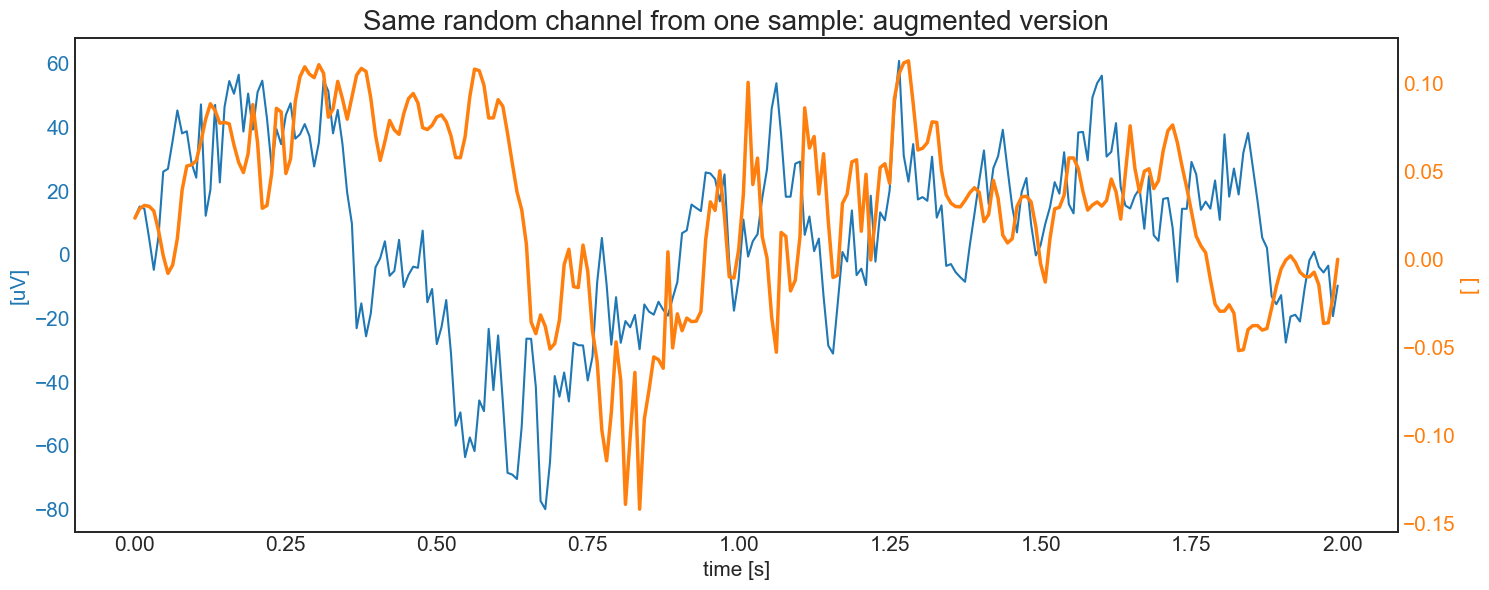

In [5]:
# VISUALIZE A RANDOM DATA AUGMENTATION
Sample = trainset.__getitem__(random.randint(0,len(trainset)))
t = np.linspace(0, Sample.shape[1]-1, Sample.shape[1])/freq
SampleAug = Augmenter(Sample)
RandChan= random.randint(0,Chan-1)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time [s]', fontsize=15)
ax1.set_ylabel('[uV]', color=color, fontsize=15)
ax1.plot(t,  Sample[RandChan,:], color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('[ ]', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(t, SampleAug[RandChan,:],color=color, linewidth=2.5)
ax2.tick_params(axis='y', labelsize=15, labelcolor=color)
plt.title('Same random channel from one sample: augmented version', fontsize=20)
fig.tight_layout()
plt.show()

### Define pretraining model and other training objects

Now we need to define the pretraining model. To do that, one must:

1. instantiate an nn.Module defining the encoder (backbone)
2. instantiate the right SSL module, giving the encoder and the network head's spec.

For now, let's use a simple EEGNet with default parameters, and SimCLR as the SSL algorithm.

<div class="alert alert-info">
<b>NOTE 1:</b> each model in the <b>models</b> module have an extra class with only the encoder with the name <b>modelnameEncoder</b> (e.g., EEGNetEncoder). This will make model creation much easier. 
</div>

<div class="alert alert-info">
<b>NOTE 2:</b> each model in the <b>ssl</b> module can accept a list or a nn.Module to create the network head. In case of a list, the head will be a sequence of dense layer with input and output size equal to the values of the list. Batchnorm and activation are based on the original works.
</div>

<div class="alert alert-warning">
<b>WARNING:</b> Remember to check if the encoder output size matches the head input size. All modules in the ssl class doesn't check that.
</div>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder
NNencoder= selfeeg.models.ShallowNetEncoder(Chans=Chan, F=8)
NNencoder2= copy.deepcopy(NNencoder) # It's suggested to copy the random initialization for embedding analysis

# SSL model
head_size=[ 88, 64, 64]
SelfMdl = selfeeg.ssl.SimCLR(encoder=NNencoder, projection_head=head_size).to(device=device)

# loss (fit method has a default loss based on the SSL algorithm
loss=selfeeg.losses.SimCLR_loss
loss_arg={'temperature': 0.5}

# earlystopper
earlystop = selfeeg.ssl.EarlyStopping(patience=25, min_delta=1e-05, record_best_weights=True)
# optimizer
optimizer = torch.optim.Adam(SelfMdl.parameters(), lr=1e-3)
# lr scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

### Pretrain the model

Each SSL algorithm has an already implemented fit method, similar to scikitlearn or Keras. Of course it's not complete as the fit of bigger framewoks, but it certainly save you lots of lines of code and help you monitorate the training.

In [7]:
loss_info = SelfMdl.fit(train_dataloader = trainloader, augmenter=Augmenter, epochs=5,
                        optimizer=optimizer, loss_func= loss, loss_args= loss_arg,
                        lr_scheduler= scheduler, EarlyStopper=earlystop,
                        validation_dataloader=valloader,
                        verbose=True, device= device, return_loss_info=True
                       )

epoch [1/5]
   val 20/20: 100%|███████████████| 161/161 [ 6.16 Batch/s, train_loss=4.55806, val_loss=4.97115]  
epoch [2/5]
   val 20/20: 100%|███████████████| 161/161 [ 6.69 Batch/s, train_loss=4.28011, val_loss=4.83497]  
epoch [3/5]
   val 20/20: 100%|███████████████| 161/161 [ 6.43 Batch/s, train_loss=4.21057, val_loss=5.05810]  
epoch [4/5]
   val 20/20: 100%|███████████████| 161/161 [ 6.76 Batch/s, train_loss=4.15144, val_loss=4.75601]  
epoch [5/5]
   val 20/20: 100%|███████████████| 161/161 [ 6.44 Batch/s, train_loss=4.08906, val_loss=4.77334]  


## Fine-tuning Phase

Now that the encoder is pretrained, let's perform fine-tuning. To do that, we need to recreate the right dataloaders and models. After that, the **selfeeg** library provides a **fine-tuning** function that is similar to the fit method.

### Define fine-tuning dataloaders

This phase is basically the same as the previous one. The only differences are:

1. We are using the fine-tuning data
2. We are creating a test set for evaluation
3. We need to extract a label from each sample.

The used classes and methods are the same already used from the dataloading module

In [8]:
# Extract only the samples for fine-tuning
filesFT= EEGsplit.loc[EEGsplit['split_set']==2, 'file_name'].values
EEGlenFT= EEGlen.loc[EEGlen['file_name'].isin(filesFT)].reset_index().drop(columns=['index'])
labels = classes[ EEGsplit[EEGsplit['split_set']==2].index.tolist()]

# split the fine-tuning data in train-test-validation
EEGsplitFT = dl.GetEEGSplitTable(partition_table=EEGlenFT, test_ratio = 0.2, val_ratio= 0.1, val_ratio_on_all_data=False,
                                 stratified=True, labels=labels, split_tolerance=0.001, perseverance=10000)

# TRAINING DATALOADER
trainsetFT = dl.EEGDataset(EEGlenFT, EEGsplitFT, [freq, window, overlap], 'train', 
                           supervised=True, label_on_load=True, 
                           load_function=loadEEG, optional_load_fun_args=[True])
trainsamplerFT = dl.EEGsampler(trainsetFT, batchsize, workers)
trainloaderFT = DataLoader(dataset = trainsetFT, batch_size= batchsize, sampler=trainsamplerFT, num_workers=workers)

# VALIDATION DATALOADER
valsetFT = dl.EEGDataset(EEGlenFT, EEGsplitFT, [freq, window, overlap], 'validation', 
                         supervised=True, label_on_load=True, 
                         load_function=loadEEG, optional_load_fun_args=[True])
valloaderFT = DataLoader(dataset = valsetFT, batch_size= batchsize, num_workers=workers, shuffle=False)

#TEST DATALOADER
testsetFT = dl.EEGDataset(EEGlenFT, EEGsplitFT, [freq, window, overlap], 'test', 
                          supervised=True, label_on_load=True, 
                          load_function=loadEEG, optional_load_fun_args=[True])
testloaderFT = DataLoader(dataset = testsetFT, batch_size= batchsize, shuffle=False)

dl.check_split(EEGlenFT, EEGsplitFT, labels)


train ratio:      0.72
validation ratio: 0.08
test ratio:       0.20

train labels ratio: 0.0=0.620,  1.0=0.380, 
val   labels ratio: 0.0=0.627,  1.0=0.373, 
test  labels ratio: 0.0=0.617,  1.0=0.383, 



### Define fine-tuning model and other training objects

Remember that in this phase you need to transfer the pretrained encoder

In [9]:
FinalMdl = selfeeg.models.ShallowNet(nb_classes = 2, Chans = Chan, Samples = int(freq*window), F=8)

# Transfer the pretrained backbone and move the final model to the right device
SelfMdl.train() 
SelfMdl.to(device='cpu') 
FinalMdl.encoder = SelfMdl.get_encoder()
FinalMdl.train()
FinalMdl.to(device=device)

# DEFINE LOSS
def loss_fineTuning(yhat, ytrue):
    ytrue = ytrue + 0.
    yhat = torch.squeeze(yhat)
    return F.binary_cross_entropy_with_logits(yhat, ytrue)

# DEFINE EARLYSTOPPER
earlystopFT = selfeeg.ssl.EarlyStopping(patience=10, min_delta=1e-03, record_best_weights=True)

# DEFINE OPTIMIZER 
optimizerFT = torch.optim.Adam(FinalMdl.parameters(), lr=1e-3)
schedulerFT = torch.optim.lr_scheduler.ExponentialLR(optimizerFT, gamma=0.97)

### Fine-tuning

Fine-tuning can be easily performed with the fine-tuning method.

<div class="alert alert-info">
<b>NOTE 1:</b> it is better to first pretrain only the new head, and then update all model's weights. However, EEGNet is small and this is a simple example, so we directly fine-tune all the network.
</div>

In [10]:
finetuning_loss=selfeeg.ssl.fine_tune(model                 = FinalMdl,
                                      train_dataloader      = trainloaderFT,
                                      epochs                = 10,
                                      optimizer             = optimizerFT,
                                      loss_func             = loss_fineTuning, 
                                      lr_scheduler          = schedulerFT,
                                      EarlyStopper          = earlystopFT,
                                      validation_dataloader = valloaderFT,
                                      verbose               = True,
                                      device                = device,
                                      return_loss_info      = True
                                     )

epoch [1/10]
   val 4/4: 100%|███████████████| 33/33 [11.08 Batch/s, train_loss=0.71636, val_loss=0.50470]  
epoch [2/10]
   val 4/4: 100%|███████████████| 33/33 [12.15 Batch/s, train_loss=0.44192, val_loss=0.33545]  
epoch [3/10]
   val 4/4: 100%|███████████████| 33/33 [12.74 Batch/s, train_loss=0.28527, val_loss=0.17611]  
epoch [4/10]
   val 4/4: 100%|███████████████| 33/33 [12.11 Batch/s, train_loss=0.15588, val_loss=0.12585]  
epoch [5/10]
   val 4/4: 100%|███████████████| 33/33 [11.13 Batch/s, train_loss=0.10486, val_loss=0.07472]  
epoch [6/10]
   val 4/4: 100%|███████████████| 33/33 [12.49 Batch/s, train_loss=0.07694, val_loss=0.05704]  
epoch [7/10]
   val 4/4: 100%|███████████████| 33/33 [13.33 Batch/s, train_loss=0.09269, val_loss=0.05536]  
epoch [8/10]
   val 4/4: 100%|███████████████| 33/33 [12.06 Batch/s, train_loss=0.06271, val_loss=0.05572]  
epoch [9/10]
   val 4/4: 100%|███████████████| 33/33 [12.06 Batch/s, train_loss=0.05042, val_loss=0.04240]  
epoch [10/10]
   va

## Evaluate fine-tuned model

Now you can evaluate your model in whatever method you prefer. Here is a simple example with the classification report from sklearn.

In [11]:
from sklearn.metrics import classification_report
nb_classes=2
FinalMdl.eval()
ytrue=torch.zeros(len(testloaderFT.dataset))
ypred=torch.zeros_like(ytrue)
cnt=0
for i, (X, Y) in enumerate(testloaderFT):
    X=X.to(device=device)
    ytrue[cnt:cnt+X.shape[0]]= Y 
    with torch.no_grad():
        yhat = torch.sigmoid(FinalMdl(X)).to(device='cpu')
        ypred[cnt:cnt+X.shape[0]] = torch.squeeze(yhat) 
    cnt += X.shape[0]

print('Results of trivial Example\n')
print(classification_report(ytrue,ypred>0.5))



Results of trivial Example

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        58
         1.0       1.00      1.00      1.00        70

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

